# Demo 3: Trying out a different Model

**Authored by:** Joshua Isanan

**Date:** 07/28/2024

This notebook will mainly contain almost the same code blocks as the previous Demo notebook, with changes to our experiment runs, as well as our Hyperparameter search space.

In [1]:
from azure.ai.ml import MLClient
from azure.identity import DefaultAzureCredential
import numpy as np

resource_group = "RESOURCE GROUP"
subscription_id = "SUBSCRIPTION ID"
workspace = "WORKSPACE NAME"

ml_client = MLClient(
    DefaultAzureCredential(), subscription_id, resource_group, workspace
)

In [3]:
dataset =  ml_client.data.get(name="purchase-prediction-dataset", version="1")

In [4]:
import pandas as pd
import numpy as np

dataset = pd.read_csv(dataset.path)

In [5]:
m = dataset.select_dtypes(np.number)
dataset[m.columns]= m.round().astype('float')
dataset["PurchaseStatus"]= dataset["PurchaseStatus"].astype('float')

In [6]:
import mlflow

mlflow.set_experiment(experiment_name="purchase-prediction-random-forest-experiment")

<Experiment: artifact_location='', creation_time=1721766400146, experiment_id='384eddcc-f41d-4683-a54c-ac57f39e83a7', last_update_time=None, lifecycle_stage='active', name='purchase-prediction-random-forest-experiment', tags={}>

In [7]:
%pip install xgboost
%pip install matplotlib
%pip install shap
%pip install hyperopt

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [8]:
from mlflow.models import infer_signature
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    dataset.drop("PurchaseStatus", axis=1), dataset["PurchaseStatus"], test_size=0.3, random_state=5)

signature = infer_signature(X_test, y_test)

In [9]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder

preprocessor = ColumnTransformer(
    [
        ('column_dropper', 'drop', ["Gender"]),
        (
        "cat_encoding",
        OrdinalEncoder(
            categories="auto",
            encoded_missing_value=np.nan,
        ),
        ["ProductCategory"],
        )
    ],
    remainder="passthrough",
    verbose_feature_names_out=False,
)

pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor)
    ]
)

In [10]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

criterion_choices = ['log_loss', 'entropy', 'gini']
max_feature_choices = ['sqrt','log2', None]
space = {'criterion': hp.choice('criterion', criterion_choices),
          'max_depth': hp.quniform('max_depth', 10, 1200, 10),
          'max_features': hp.choice('max_features', max_feature_choices),
          'min_samples_leaf': hp.uniform('min_samples_leaf', 0, 1),
          'min_samples_split' : hp.uniform ('min_samples_split', 0, 1),
          'n_estimators' : hp.uniform('n_estimators', 10, 1500)
        }


In [11]:
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from typing import Any, Dict
import warnings
warnings.filterwarnings('ignore')

def objective(space: Dict[str, Any], pipeline:None):
    with mlflow.start_run(nested=True, run_name="hyperopt" + "_".join(space.keys())) as child_run:
        mlflow.sklearn.autolog(silent=True)

        clf=RandomForestClassifier(
                        criterion =space['criterion'], max_depth = int(space['max_depth']), max_features = space['max_features'],
                        min_samples_leaf = float(space['min_samples_leaf']), min_samples_split=float(space['min_samples_split']),
                        n_estimators=int(space['n_estimators']))
        
        eval_set = [(pipeline.fit_transform(X_test), y_test)]
        pipeline.steps.append(['model', clf])

        pipeline.fit(X_train, y_train)

        pred = pipeline.predict(X_test)
        f1_result = f1_score(y_test, pred)
        mlflow.log_metric("f1_score", f1_result)
        mlflow.log_param("hyperparameters", space)
        pipeline.steps.pop(1)
        return {'loss': -f1_result, 'status': STATUS_OK, "attachments": {"run_id": child_run.info.run_id}}

Working in MLflow run: 99f60fa6-3d3c-42b1-a824-d344b3dbee01
 57%|█████▋    | 57/100 [09:27<07:08,  9.96s/trial, best loss: -0.9170731707317074]
Showing Histogram of 57 jobs


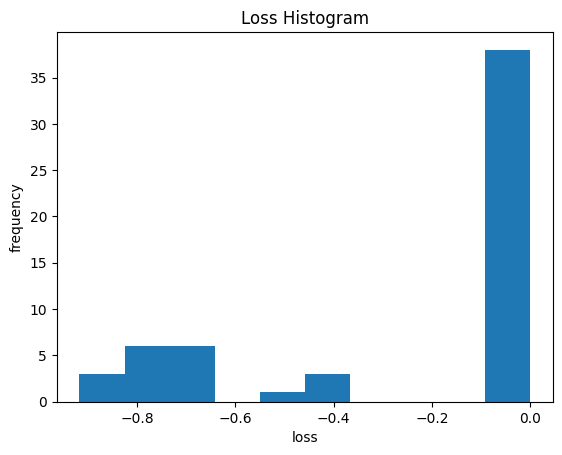

In [12]:
from hyperopt.early_stop import no_progress_loss
from functools import partial

import hyperopt.plotting
import matplotlib.pyplot as plt

with mlflow.start_run(run_name="hyperopt_tuning") as tuning_run:
    print("Working in MLflow run:", tuning_run.info.run_id)
    trials = Trials()
    best_params = fmin(
        fn=partial(objective, pipeline = pipeline),
        space=space,
        algo=tpe.suggest,
        max_evals=100,
        trials=trials,
        early_stop_fn=no_progress_loss(30)
    )

    
    best_run_id = trials.trial_attachments(trials.best_trial)["run_id"]

    client = mlflow.tracking.MlflowClient()

    mlflow.log_param("best_run_id", best_run_id)
    mlflow.log_params({f"best_{p}": v for p, v in best_params.items()})
    mlflow.log_metric("best_f1_score", -trials.best_trial["result"]["loss"])

    clf=RandomForestClassifier(
        criterion = criterion_choices[best_params['criterion']],
        max_depth = int(best_params['max_depth']),
        max_features = max_feature_choices[best_params['max_features']],
        min_samples_leaf=float(best_params['min_samples_leaf']),
        min_samples_split=float(best_params['min_samples_split']),
        n_estimators=int(best_params['n_estimators'])
    )

    eval_set = [(pipeline.fit_transform(X_test), y_test)]
    pipeline.steps.append(['model', clf])

    pipeline.fit(X_train, y_train)

    best_model = mlflow.sklearn.log_model(pipeline, artifact_path="pipeline", signature=signature)

    fig = plt.figure()
    ax = fig.add_subplot()
    hyperopt.plotting.main_plot_histogram(trials, do_show=False)
    mlflow.log_figure(fig, "loss_histogram.png")


In [13]:
best_params

{'criterion': 1,
 'max_depth': 10.0,
 'max_features': 2,
 'min_samples_leaf': 0.0028008653510021436,
 'min_samples_split': 0.02253941502240281,
 'n_estimators': 1475.917862447134}

Let's load our baseline model (the one from Demo 2) to check if this new model trained with RF will perform better.

In [14]:
baseline_model = ml_client.models.get(name="baseline_model", version="2")

In [15]:
from mlflow.models import MetricThreshold

# Define criteria for model to be validated against
thresholds = {
    "f1_score": MetricThreshold(
        threshold=0.8,  # f1score should be >=0.8
        min_absolute_change=0.03,  # f1score should be at least 0.03 greater than baseline model f1score
        min_relative_change=0.03,  # f1score should be at least 3 percent greater than baseline model f1score
        greater_is_better=True,
    ),
}

with mlflow.start_run(run_name="Baseline Model vs. RF Model") as run:
    eval_data = X_test
    eval_data["PurchaseStatus"] = y_test

    mlflow.evaluate(
        # baseline_model.properties['mlflow.modelSourceUri'],
        best_model.model_uri,
        eval_data,
        targets="PurchaseStatus",
        model_type="classifier",
        evaluators=["default"],
        validation_thresholds=thresholds,
        baseline_model=baseline_model.properties['mlflow.modelSourceUri'],
    )


2024/07/28 00:26:12 INFO mlflow.models.evaluation.default_evaluator: Evaluating candidate model:
2024/07/28 00:26:12 INFO mlflow.models.evaluation.default_evaluator: Computing model predictions.
2024/07/28 00:26:13 INFO mlflow.models.evaluation.default_evaluator: The evaluation dataset is inferred as binary dataset, positive label is 1.0, negative label is 0.0.
2024/07/28 00:26:14 INFO mlflow.models.evaluation.default_evaluator: Testing metrics on first row...
2024/07/28 00:26:17 INFO mlflow.models.evaluation.default_evaluator: Shap explainer ExactExplainer is used.
ExactExplainer explainer: 451it [14:05,  1.89s/it]                         
2024/07/28 00:45:32 INFO mlflow.models.evaluation.default_evaluator: Evaluating baseline model:
2024/07/28 00:45:32 INFO mlflow.models.evaluation.default_evaluator: Computing model predictions.
2024/07/28 00:45:32 INFO mlflow.models.evaluation.default_evaluator: The evaluation dataset is inferred as binary dataset, positive label is 1.0, negative la

ModelValidationFailedException: Metric f1_score minimum absolute change check failed: candidate model f1_score = 0.9238329238329238, baseline model f1_score = 0.95, f1_score minimum absolute change threshold = 0.03. Metric f1_score minimum relative change check failed: candidate model f1_score = 0.9238329238329238, baseline model f1_score = 0.95, f1_score minimum relative change threshold = 0.03.

This time our experiment failed due to our new model being worse than the baseline we compared it with.